### 90803 Final Project

# Q3: Unsupervised Learning/Clustering for Cities

**Team 14**

Chi-Shiun Tsai & Colton Lapp

**What are some ways we can cluster cities into categories based on all available data, and will this reveal any patterns about city development?**

Models:
1. K-means clustering
2. Hierarchical clustering
3. DBSCAN
4. Gaussian Mixture Model

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import RobustScaler, PowerTransformer
import geopandas as gpd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
import scipy as sp
from scipy.cluster.hierarchy import linkage, dendrogram
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance
from sklearn.decomposition import PCA

%matplotlib inline
pd.set_option('display.max_columns', 500)

#### Set Seed

In [2]:
seed = 0

### Read in Data

In [3]:
#Set Base Dir
base_dir = os.getcwd().split('/')
base_dir = '/'.join(base_dir[0:-1])
base_dir
df = pd.read_csv(base_dir + '/Team14_CL_CT_MG/data/data_all.csv', low_memory=False)
df.head(3)

,Name,Population 2020,Median Household Income,Median Home Value,Median Gross Rent,Renter Household,Total Housing Units,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Population Age 25 or Older: Doctorate Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 15 or Older Never Married 2,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Took Public Transportation to work,Workers 16 or more who Worked at Home,Workers 16 or more who Drove Alone to Work,Employed in Professional/Scientific/Technical Services,Employed in Accommodation/Food Services,Employed in Health Care/Social Assistance,Employed in Arts/Entertainment/Recreation,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households with No Internet Acces,Households Receiving Food Stamps/SNAP,Households Below the Poverty Leve,Gross Rent 50% + of Household Income,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,state,place,GEOID,Population 2019,Pop Chng %,land_area,water_area,cases_per_100K,deaths_per_100K
0,"New York city, New York",8379552,67046.0,635200.0,1489.0,2143429.0,42.002186,41.330205,28.925997,16.000569,1.125072,7.664813,17.610035,18.069295,14.947255,4.979001,1.908419,46.830821,24.736883,3.465794,10.448387,4.848242,3.531358,8.708186,1.403011,1.143271,1.902047,1.705306,8.383276,3.427486,5.030627,7.244218,6.556830,6.763679,0.208245,3.913145,0.719466,36,51000,3651000,8419316,-0.472295,777982727,434642000,5913.616647,220.640533
1,"Los Angeles city, California",3973278,65290.0,670700.0,1523.0,884176.0,38.099297,48.930480,48.066307,16.225771,1.007329,5.683670,19.986897,17.982834,12.855557,3.889962,1.788574,49.252959,4.056122,4.517605,33.341664,4.703748,4.288298,6.098239,2.086111,1.660996,1.278365,2.068393,7.988391,5.480588,3.824172,3.640193,5.838303,6.734288,0.256715,2.800433,0.887101,6,44000,644000,3966936,0.159871,1214591312,87468461,6178.068445,67.066531
2,"Chicago city, Illinois",2699347,62097.0,267600.0,1154.0,590848.0,45.110392,47.731581,28.628813,16.758127,1.200438,8.816058,20.245897,19.983537,12.676177,4.820647,1.800250,49.382610,12.919050,4.194570,23.775417,6.130186,4.004228,7.006176,1.199698,1.064406,2.110918,2.475895,5.359926,4.764597,5.445095,7.012289,6.614933,5.035996,0.455777,5.058372,0.868655,17,14000,1714000,2709534,-0.375969,588881854,17621529,7499.869841,133.847542


## Set Up Data

### Adjust Row Names
Note: If we want to include state effects, we could keep that column and create boolean values out of it

In [4]:
#Set row equal to name
df.set_index('Name', inplace=True, drop=True)

#Drop GEOID and STATE column
df = df.drop( ['GEOID', 'state'], axis=1)
df.head(3)

,Population 2020,Median Household Income,Median Home Value,Median Gross Rent,Renter Household,Total Housing Units,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Population Age 25 or Older: Doctorate Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 15 or Older Never Married 2,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Took Public Transportation to work,Workers 16 or more who Worked at Home,Workers 16 or more who Drove Alone to Work,Employed in Professional/Scientific/Technical Services,Employed in Accommodation/Food Services,Employed in Health Care/Social Assistance,Employed in Arts/Entertainment/Recreation,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households with No Internet Acces,Households Receiving Food Stamps/SNAP,Households Below the Poverty Leve,Gross Rent 50% + of Household Income,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,place,Population 2019,Pop Chng %,land_area,water_area,cases_per_100K,deaths_per_100K
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"New York city, New York",8379552,67046.0,635200.0,1489.0,2143429.0,42.002186,41.330205,28.925997,16.000569,1.125072,7.664813,17.610035,18.069295,14.947255,4.979001,1.908419,46.830821,24.736883,3.465794,10.448387,4.848242,3.531358,8.708186,1.403011,1.143271,1.902047,1.705306,8.383276,3.427486,5.030627,7.244218,6.556830,6.763679,0.208245,3.913145,0.719466,51000,8419316,-0.472295,777982727,434642000,5913.616647,220.640533
"Los Angeles city, California",3973278,65290.0,670700.0,1523.0,884176.0,38.099297,48.930480,48.066307,16.225771,1.007329,5.683670,19.986897,17.982834,12.855557,3.889962,1.788574,49.252959,4.056122,4.517605,33.341664,4.703748,4.288298,6.098239,2.086111,1.660996,1.278365,2.068393,7.988391,5.480588,3.824172,3.640193,5.838303,6.734288,0.256715,2.800433,0.887101,44000,3966936,0.159871,1214591312,87468461,6178.068445,67.066531
"Chicago city, Illinois",2699347,62097.0,267600.0,1154.0,590848.0,45.110392,47.731581,28.628813,16.758127,1.200438,8.816058,20.245897,19.983537,12.676177,4.820647,1.800250,49.382610,12.919050,4.194570,23.775417,6.130186,4.004228,7.006176,1.199698,1.064406,2.110918,2.475895,5.359926,4.764597,5.445095,7.012289,6.614933,5.035996,0.455777,5.058372,0.868655,14000,2709534,-0.375969,588881854,17621529,7499.869841,133.847542


## Final data cleaning

In [5]:
#Drop rows with infinite growth rates
starting_rows = df.shape[0]

# Find the indices of positive or negative infinity
inf_indices = np.isinf(df['Pop Chng %'])

# Drop rows
df = df[~inf_indices]

# Replace the missing value code from census data
df = df.replace(-666666666, np.nan)

#Forgot to normalize renter HH by population 
df['Renter Household'] = df['Renter Household']/df['Population 2020']

# Add the two never married columns together
df['Population Age 15 or Older Never Married'] = df['Population Age 15 or Older Never Married'] + df['Population Age 15 or Older Never Married 2']
df.drop(['Population Age 15 or Older Never Married 2'], axis=1, inplace=True)

#Drop rows with NaN
df = df.dropna()

print("Went from {} rows to {} rows after cleaning".format(starting_rows, df.shape[0]))

Went from 19495 rows to 16665 rows after cleaning


Categorize cities based on population size (same as what we did for Q1)

In [6]:
# Set cutoff points
small_cut = 5000
med_cut = 50000

# Create variable to classify city as small/medium/large
def class_city(row):
    if row['Population 2020'] < small_cut:
        return "small"
    elif row['Population 2020'] < med_cut:
        return "medium"
    else:
        return "big"
    
# Create new 'size' column using the apply function
df['City_Size'] = df.apply(lambda row: class_city(row), axis=1)  

# Get the counts of each size
df['City_Size'].value_counts()

small     11920
medium     3970
big         775
Name: City_Size, dtype: int64

We will run clustering for each size category.

# Data Transformations

### Take Log of skewed variables


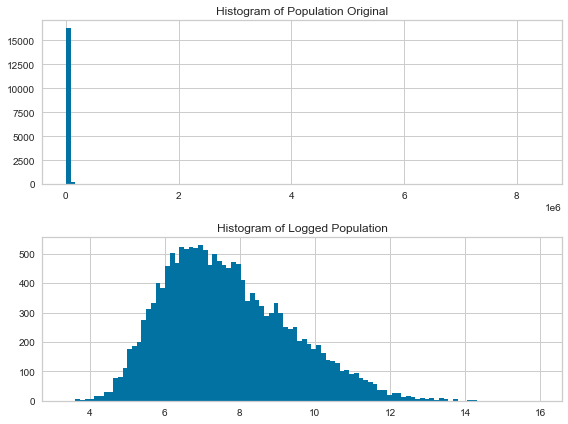

In [7]:
#Take Log of Population
df['Population 2020 Log'] = np.log(df['Population 2020'])

fig, axs = plt.subplots(2, 1, figsize=(8, 6))
axs[0].hist( df['Population 2020'], bins=100)
axs[0].set_title('Histogram of Population Original')

axs[1].hist(df['Population 2020 Log'], bins=100)
axs[1].set_title('Histogram of Logged Population')

fig.tight_layout()
plt.show()

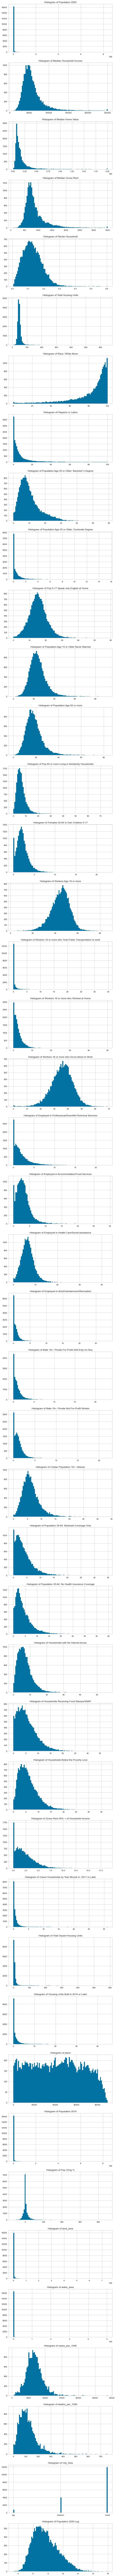

In [8]:
# Create a figure with subplots for each column
fig, axs = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(8, 4*len(df.columns)))

# Plot every 
for i, col in enumerate(df.columns):
    axs[i].hist(df[col], bins=100)
    axs[i].set_title(f'Histogram of {col}')
    
#Formatting
fig.tight_layout()
plt.show()

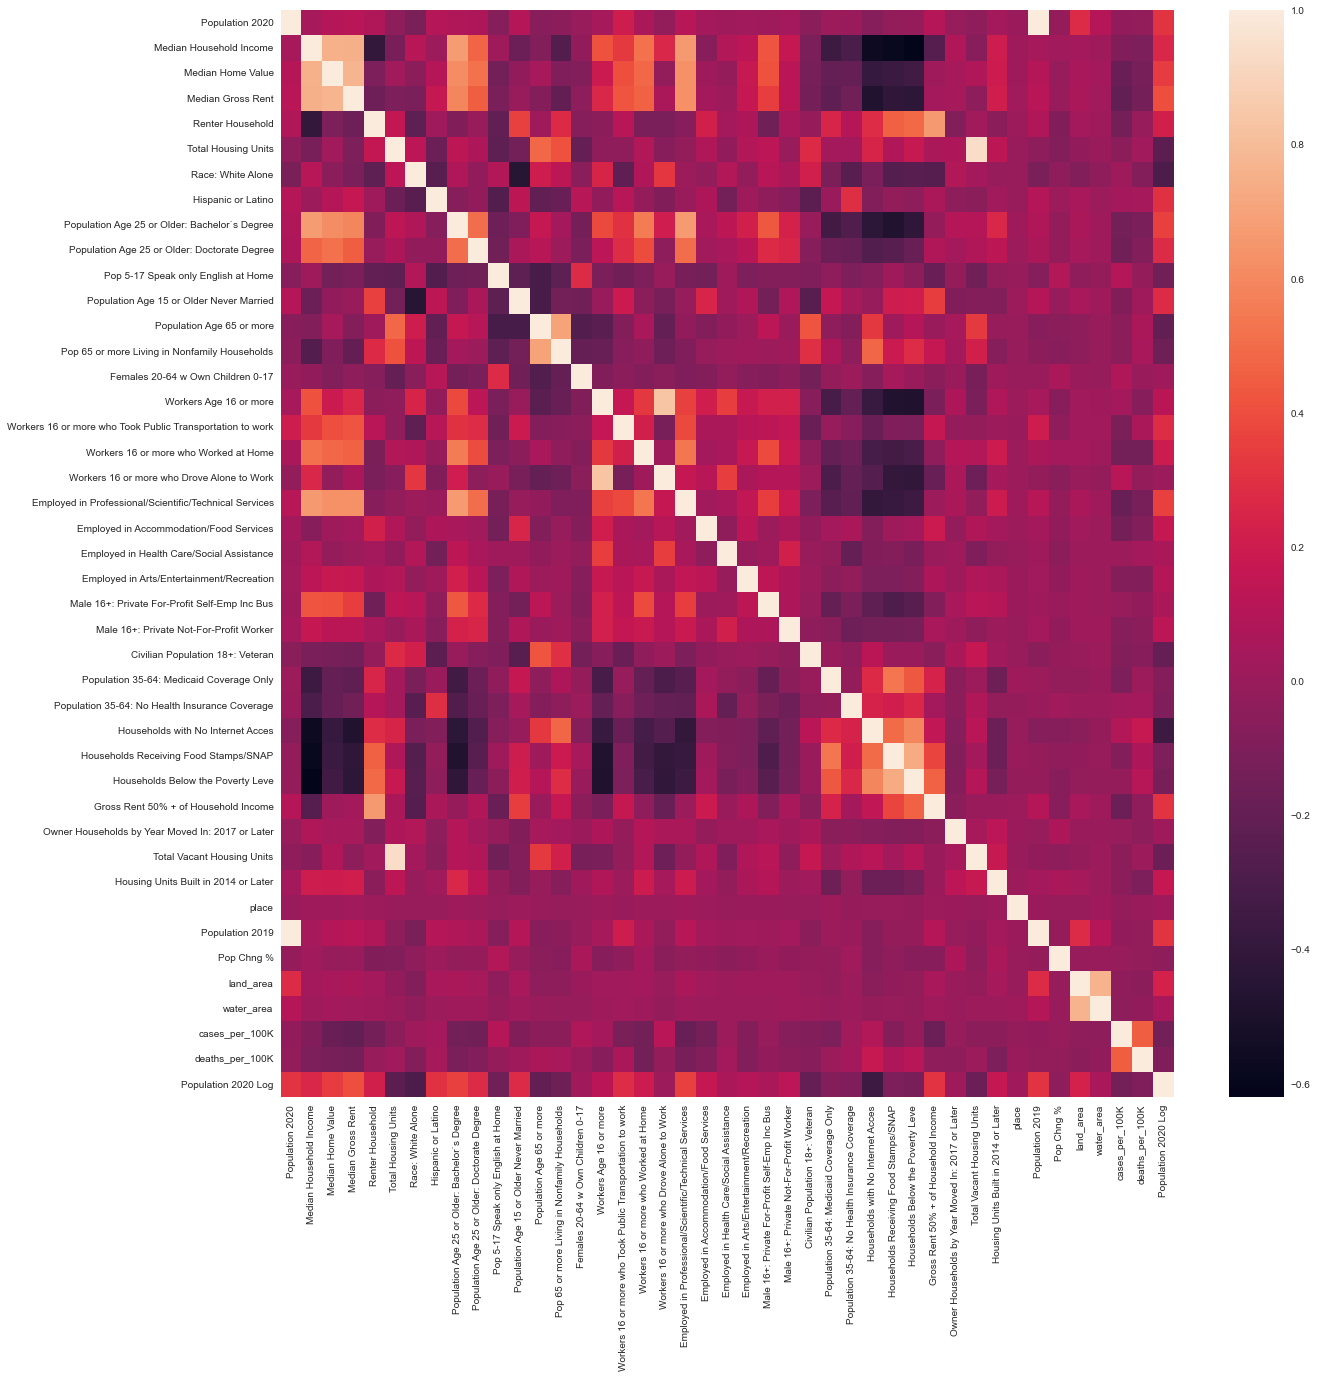

In [9]:
# Check correlation
corr = df.corr()
# plot the heatmap
plt.figure(figsize=(20,20))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()

# Scale Data

In [10]:
df.columns

Index(['Population 2020', 'Median Household Income', 'Median Home Value',
       'Median Gross Rent', 'Renter Household', 'Total Housing Units',
       'Race: White Alone', 'Hispanic or Latino',
       'Population Age 25 or Older: Bachelor`s Degree',
       'Population Age 25 or Older: Doctorate Degree',
       'Pop 5-17 Speak only English at Home',
       'Population Age 15 or Older Never Married', 'Population Age 65 or more',
       'Pop 65 or more Living in Nonfamily Households',
       'Females 20-64 w Own Children 0-17', 'Workers Age 16 or more',
       'Workers 16 or more who Took Public Transportation to work',
       'Workers 16 or more who Worked at Home',
       'Workers 16 or more who Drove Alone to Work',
       'Employed in Professional/Scientific/Technical Services',
       'Employed in Accommodation/Food Services',
       'Employed in Health Care/Social Assistance',
       'Employed in Arts/Entertainment/Recreation',
       'Male 16+: Private For-Profit Self-Emp Inc Bus'

In [11]:
X = df.drop(['Population 2020', 'Population 2019', 'Pop Chng %', 'Population 2020 Log', 
             'Population Age 25 or Older: Doctorate Degree',
             'Median Gross Rent', 'Renter Household', 'Total Housing Units',
             'Workers 16 or more who Took Public Transportation to work',
             'Workers 16 or more who Worked at Home',
             'Employed in Accommodation/Food Services',
             'Employed in Professional/Scientific/Technical Services',
             'Employed in Arts/Entertainment/Recreation',
             'Households with No Internet Acces',
             'Households Receiving Food Stamps/SNAP',
             'Gross Rent 50% + of Household Income',
             'Employed in Health Care/Social Assistance'
              ], axis=1)

# create a RobustScaler object
scaler = RobustScaler()

# select only numeric columns
num_cols = X.select_dtypes(include=['int', 'float']).columns

# fit and transform the scaler on the numeric columns
X[num_cols] = scaler.fit_transform(X[num_cols])

X.head()

,Median Household Income,Median Home Value,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Drove Alone to Work,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households Below the Poverty Leve,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,place,land_area,water_area,cases_per_100K,deaths_per_100K,City_Size
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,
"New York city, New York",0.647260,5.096647,-2.530708,2.758687,0.997219,-1.096272,1.369148,-0.281360,-0.153786,-0.042021,0.152408,-2.553245,0.426612,0.818141,-1.168187,1.411508,0.052330,0.309205,-0.155182,-0.194989,0.313827,0.225610,65.848890,2494.931064,-0.234153,1.472968,big
"Los Angeles city, California",0.574755,5.446746,-2.135390,4.871871,1.027335,-1.393215,1.613933,-0.528429,-0.419518,-0.115254,0.379049,-0.268427,0.888836,0.297351,-1.063775,1.307306,0.585054,0.157757,-0.094837,-0.378486,0.449965,0.055430,103.035288,502.017359,-0.141697,-0.430632,big
"Chicago city, Illinois",0.442917,1.471400,-2.197749,2.725876,1.098528,-0.923717,1.855438,-0.549617,-0.192426,-0.108119,0.391180,-1.223167,0.356201,0.992553,-0.946590,0.613710,0.399274,0.321452,0.152995,-0.006130,0.434985,-0.673911,49.742976,101.068288,0.320419,0.397140,big
"Houston city, Texas",0.092076,0.674556,-1.999697,4.475036,0.672988,-1.039067,1.004736,-0.749282,-0.493252,0.205911,0.232441,0.017546,0.262019,0.146441,-0.800525,-0.106958,1.776834,0.310617,0.097172,-0.071325,1.864470,-0.163372,140.808836,466.309907,-0.556494,-0.547009,big
"Phoenix city, Arizona",0.394071,1.305720,-1.131387,4.273558,0.456140,-0.596011,0.827527,-0.750629,-0.517081,0.362118,0.344294,-0.040566,0.427782,0.253461,-0.388849,0.539544,0.825885,-0.062798,0.465314,-0.381479,0.634583,0.322855,113.781749,18.493875,0.253047,0.177649,big


## Create Dataset for Each Size Category

In [12]:
df_small = X[X['City_Size'] == 'small']
X_small = df_small.drop(['City_Size'], axis=1)

df_medium = X[X['City_Size'] == 'medium']
X_medium = df_medium.drop(['City_Size'], axis=1)

df_big = X[X['City_Size'] == 'big']
X_big = df_big.drop(['City_Size'], axis=1)

X_big.head(5)

,Median Household Income,Median Home Value,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Drove Alone to Work,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households Below the Poverty Leve,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,place,land_area,water_area,cases_per_100K,deaths_per_100K
Name,,,,,,,,,,,,,,,,,,,,,,,,,,
"New York city, New York",0.647260,5.096647,-2.530708,2.758687,0.997219,-1.096272,1.369148,-0.281360,-0.153786,-0.042021,0.152408,-2.553245,0.426612,0.818141,-1.168187,1.411508,0.052330,0.309205,-0.155182,-0.194989,0.313827,0.225610,65.848890,2494.931064,-0.234153,1.472968
"Los Angeles city, California",0.574755,5.446746,-2.135390,4.871871,1.027335,-1.393215,1.613933,-0.528429,-0.419518,-0.115254,0.379049,-0.268427,0.888836,0.297351,-1.063775,1.307306,0.585054,0.157757,-0.094837,-0.378486,0.449965,0.055430,103.035288,502.017359,-0.141697,-0.430632
"Chicago city, Illinois",0.442917,1.471400,-2.197749,2.725876,1.098528,-0.923717,1.855438,-0.549617,-0.192426,-0.108119,0.391180,-1.223167,0.356201,0.992553,-0.946590,0.613710,0.399274,0.321452,0.152995,-0.006130,0.434985,-0.673911,49.742976,101.068288,0.320419,0.397140
"Houston city, Texas",0.092076,0.674556,-1.999697,4.475036,0.672988,-1.039067,1.004736,-0.749282,-0.493252,0.205911,0.232441,0.017546,0.262019,0.146441,-0.800525,-0.106958,1.776834,0.310617,0.097172,-0.071325,1.864470,-0.163372,140.808836,466.309907,-0.556494,-0.547009
"Phoenix city, Arizona",0.394071,1.305720,-1.131387,4.273558,0.456140,-0.596011,0.827527,-0.750629,-0.517081,0.362118,0.344294,-0.040566,0.427782,0.253461,-0.388849,0.539544,0.825885,-0.062798,0.465314,-0.381479,0.634583,0.322855,113.781749,18.493875,0.253047,0.177649


# Model 1: K Means

### Step 1: Find optimal K

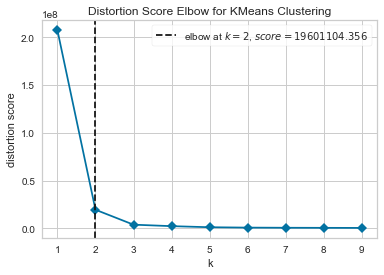

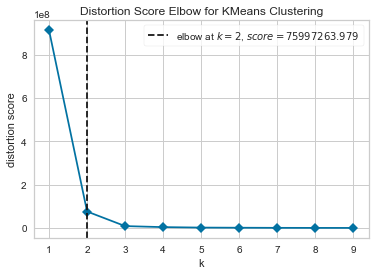

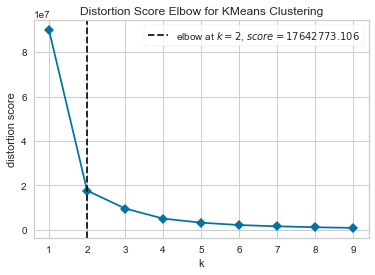

In [13]:
for i in [X_small, X_medium, X_big]:
    KM_baseline = KMeans(random_state=seed, n_init=10)
    # Elbow Method
    visualizer = KElbowVisualizer(KM_baseline,  k=(1,10), timings = False)
    visualizer.fit(i)
    visualizer.show(); 
    
    # Calinski-Harabasz Score
    # visualizer = KElbowVisualizer(KM_baseline, k=(2,15), metric='calinski_harabasz', timings=False, locate_elbow=True)
    # visualizer.fit(i)
    # visualizer.show();

In [14]:
# for df in [X_small, X_medium, X_big]:
#     fig, ax = plt.subplots(1, 4, figsize=(12,5))
#     j, h = 0, 0
#     for i in range(3,7):
#         model = KMeans(random_state=seed, n_init=10, n_clusters=i)
#         viz = SilhouetteVisualizer(model, colors='yellowbrick', ax=ax[i-3])
#         viz.fit(df)

### Step 2: Run K Means for each size category

2.1 Small Cities

In [15]:
# Create a KMeans object with the number of clusters based on the elbow plot
kmeans_small = KMeans(n_clusters=2)

# Fit the KMeans model to the data
kmeans_small.fit(X_small)

# Get the clusters for each city
labels_small = kmeans_small.labels_

X_small_clsuters = X_small.copy()
X_small_clsuters['clusters'] = labels_small
X_small_clsuters.head(5)

,Median Household Income,Median Home Value,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Drove Alone to Work,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households Below the Poverty Leve,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,place,land_area,water_area,cases_per_100K,deaths_per_100K,clusters
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Richland Center city, Wisconsin",-0.398282,-0.140039,0.082702,-0.218362,-0.064037,0.001512,0.165241,0.914926,1.653915,-0.070926,-0.244824,-0.648071,0.227769,-0.051563,-0.271667,0.477279,-0.156782,0.593312,-0.414447,0.202551,-0.270457,0.629786,0.613432,1.169566,-0.040233,-0.336281,0
"Wildwood city, New Jersey",-0.356745,1.336292,-0.403535,1.815293,-0.096316,-0.777833,-0.038582,-0.397751,-0.086254,0.740839,-0.610641,-1.191543,1.017774,-0.368097,-0.349090,2.010164,0.651641,0.893296,-0.264598,14.367115,0.364894,0.959084,-0.072812,1.578666,-1.395355,0.543182,0
"Alexandria city, Indiana",0.027747,-0.410256,0.440578,-0.421598,0.129029,-0.122368,-0.816825,0.125907,-0.189045,2.273087,-0.252126,-0.392719,-0.092627,0.586695,1.271908,0.501529,-0.123914,0.208329,0.709424,0.595419,-0.270457,-0.992147,0.166957,-0.086272,0.126754,0.547300,0
"Midfield city, Alabama",-0.336554,-0.434911,-3.954087,0.081253,-0.029026,0.626881,1.012633,-0.584647,-0.306307,-0.202824,-0.463476,-0.496205,-0.504532,0.452935,-0.648858,0.470024,1.510948,0.669551,-0.264568,0.413724,-0.042337,0.161817,0.172678,-0.086272,0.476680,0.049831,0
"Kingsford city, Michigan",-0.167513,-0.238659,-0.041700,-0.257635,0.454273,0.462021,-0.125553,0.705166,0.717331,-0.889345,-0.212973,-0.008885,-0.092426,1.492143,-0.013847,0.835674,-0.696415,0.420338,2.608731,-0.340578,-0.188969,0.038412,0.542657,3.727325,0.902849,2.123806,0


In [16]:
# Check number of cities per cluster
np.bincount(labels_small)

array([11919,     1])

2.2 Medium Cities

In [17]:
# Create a KMeans object with the number of clusters based on the elbow plot
kmeans_medium = KMeans(n_clusters=2)

# Fit the KMeans model to the data
kmeans_medium.fit(X_medium)

# Get the clusters for each city
labels_medium = kmeans_medium.labels_

X_medium_clsuters = X_medium.copy()
X_medium_clsuters['clusters'] = labels_medium 
X_medium_clsuters.head(5)

,Median Household Income,Median Home Value,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Drove Alone to Work,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households Below the Poverty Leve,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,place,land_area,water_area,cases_per_100K,deaths_per_100K,clusters
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Newark city, Ohio",-0.114001,0.109467,0.054108,-0.212091,0.196869,0.149998,0.422128,-0.184006,-0.055630,0.538720,-0.071532,-0.002989,-0.116877,0.201135,0.188846,0.744544,0.052297,0.389293,0.308361,0.095321,0.030318,0.299516,4.193970,7.098189,-0.203262,-0.413960,0
"Coral Gables city, Florida",2.173046,7.280079,-0.433797,6.013822,1.621406,-1.416103,0.907684,0.178890,-0.039625,-0.389550,0.082534,-0.288578,2.702695,1.182963,-1.112661,-0.665913,-0.158931,-0.298714,0.552891,0.110444,1.365567,-0.667834,2.438914,362.450610,1.560436,0.656781,0
"Twin Falls city, Idaho",-0.021925,0.567061,-0.103945,1.231859,0.138410,0.219525,-0.371960,-0.299989,-0.183413,0.913770,0.231735,0.278581,0.762509,0.612681,0.354787,-0.329780,0.399964,0.021701,1.754725,-0.553643,1.082541,0.998955,3.826637,1.548816,0.921205,0.377384,0
"Little Elm city, Texas",1.778604,1.500986,-1.553795,1.576447,0.828818,0.490878,0.025822,-1.249365,-0.986943,0.573752,0.503072,0.339411,0.535526,-0.183156,-0.502923,-0.584436,0.700796,-0.704109,1.550868,-0.653509,6.576489,0.031410,3.518264,60.896185,-0.711898,-0.761349,0
"Kannapolis city, North Carolina",0.187993,0.412229,-1.203674,0.965909,0.327229,0.179214,0.030958,-0.304595,-0.567395,0.376296,0.007107,0.015590,-0.102762,0.590062,0.232437,-0.156175,0.290771,-0.112665,0.455762,0.004316,2.385027,-0.158510,6.780000,8.286790,-0.270256,-0.259233,0


In [18]:
# Check number of cities per cluster
np.bincount(labels_medium)

array([3969,    1])

2.3 Big Cities

In [19]:
# Create a KMeans object with the number of clusters based on the elbow plot
kmeans_big = KMeans(n_clusters=2)

# Fit the KMeans model to the data
kmeans_big.fit(X_big)

# Get the clusters for each city
labels_big = kmeans_big.labels_

X_big_clsuters = X_big.copy()
X_big_clsuters['clusters'] = labels_big 
X_big_clsuters.head(5)

,Median Household Income,Median Home Value,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Drove Alone to Work,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households Below the Poverty Leve,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,place,land_area,water_area,cases_per_100K,deaths_per_100K,clusters
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,
"New York city, New York",0.647260,5.096647,-2.530708,2.758687,0.997219,-1.096272,1.369148,-0.281360,-0.153786,-0.042021,0.152408,-2.553245,0.426612,0.818141,-1.168187,1.411508,0.052330,0.309205,-0.155182,-0.194989,0.313827,0.225610,65.848890,2494.931064,-0.234153,1.472968,1
"Los Angeles city, California",0.574755,5.446746,-2.135390,4.871871,1.027335,-1.393215,1.613933,-0.528429,-0.419518,-0.115254,0.379049,-0.268427,0.888836,0.297351,-1.063775,1.307306,0.585054,0.157757,-0.094837,-0.378486,0.449965,0.055430,103.035288,502.017359,-0.141697,-0.430632,0
"Chicago city, Illinois",0.442917,1.471400,-2.197749,2.725876,1.098528,-0.923717,1.855438,-0.549617,-0.192426,-0.108119,0.391180,-1.223167,0.356201,0.992553,-0.946590,0.613710,0.399274,0.321452,0.152995,-0.006130,0.434985,-0.673911,49.742976,101.068288,0.320419,0.397140,0
"Houston city, Texas",0.092076,0.674556,-1.999697,4.475036,0.672988,-1.039067,1.004736,-0.749282,-0.493252,0.205911,0.232441,0.017546,0.262019,0.146441,-0.800525,-0.106958,1.776834,0.310617,0.097172,-0.071325,1.864470,-0.163372,140.808836,466.309907,-0.556494,-0.547009,0
"Phoenix city, Arizona",0.394071,1.305720,-1.131387,4.273558,0.456140,-0.596011,0.827527,-0.750629,-0.517081,0.362118,0.344294,-0.040566,0.427782,0.253461,-0.388849,0.539544,0.825885,-0.062798,0.465314,-0.381479,0.634583,0.322855,113.781749,18.493875,0.253047,0.177649,0


In [20]:
# Check number of cities per cluster
np.bincount(labels_big)

array([767,   8])

For all three size categories, the size of the clusters are very uneven. K-means clustering is not a good choice.

# Model 2: Hierarchical clustering

Plot different linkage methods

2.1.1 Complete Linkage

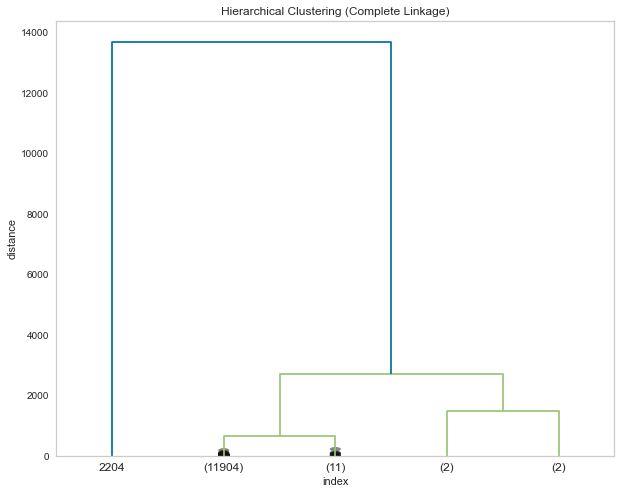

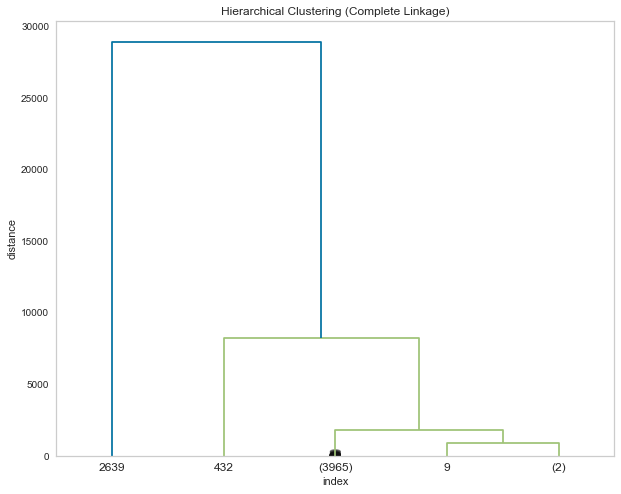

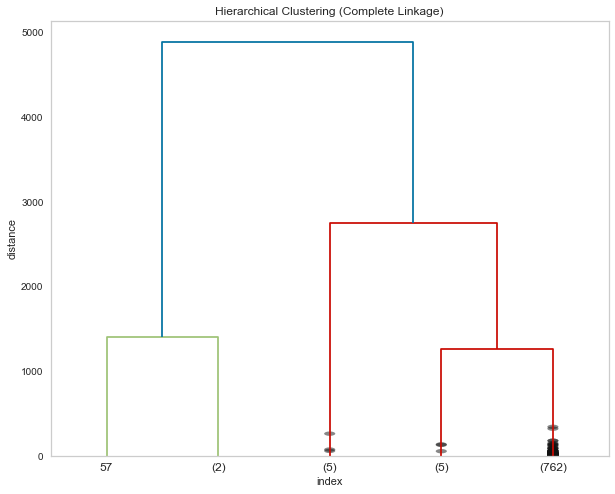

In [21]:
# Plot dendrogram
for i in [X_small, X_medium, X_big]:
        compl=linkage(i,"complete")
        plt.figure(figsize=(10,8))
        plt.grid(visible=None)
        plt.title("Hierarchical Clustering (Complete Linkage)")
        plt.xlabel("index")
        plt.ylabel("distance")
        dendrogram(compl, truncate_mode="lastp",p=5,show_contracted=True);
        plt.show()

2.1.2 Average Linkage

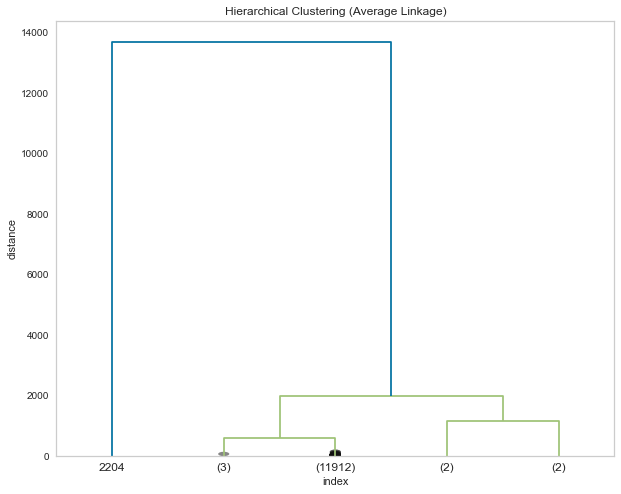

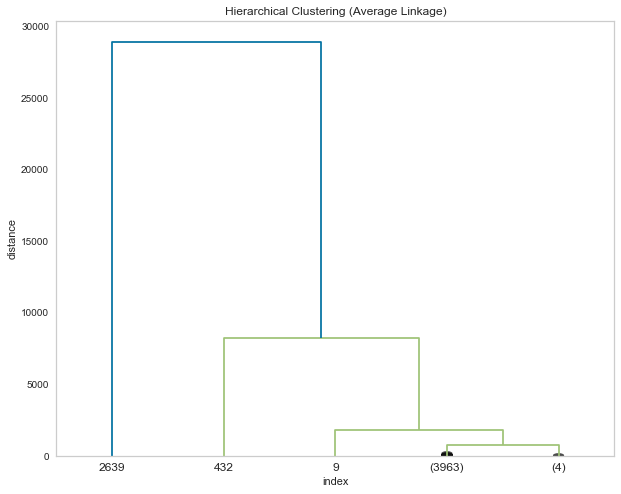

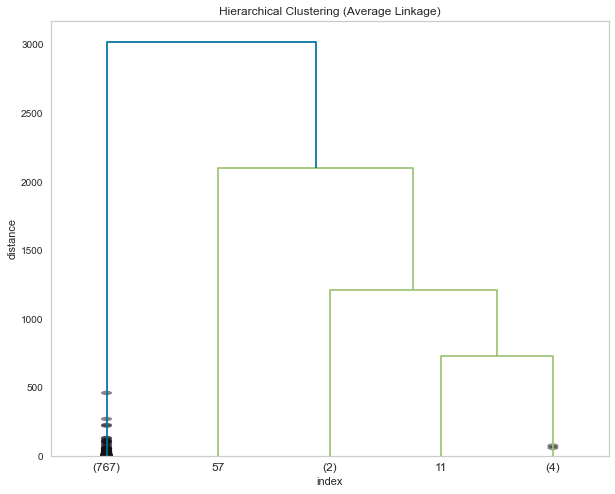

In [22]:
# Plot dendrogram
for i in [X_small, X_medium, X_big]:
        compl=linkage(i,"average")
        plt.figure(figsize=(10,8))
        plt.grid(visible=None)
        plt.title("Hierarchical Clustering (Average Linkage)")
        plt.xlabel("index")
        plt.ylabel("distance")
        dendrogram(compl, truncate_mode="lastp",p=5,show_contracted=True);
        plt.show()

2.1.3 Ward Linkage

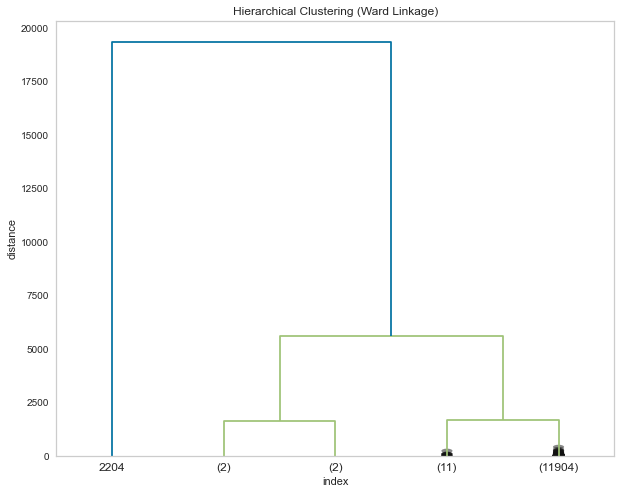

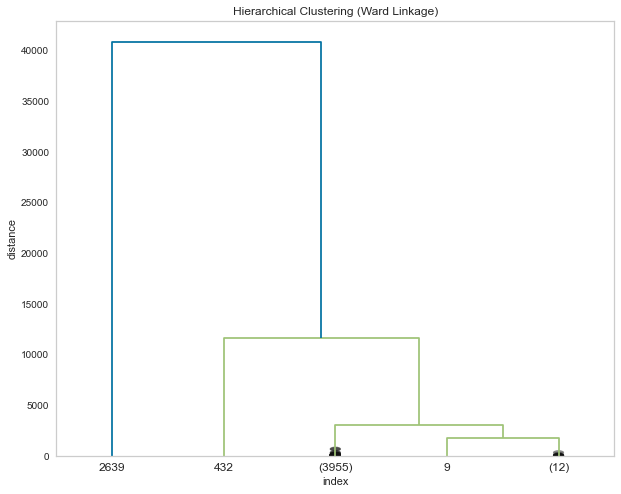

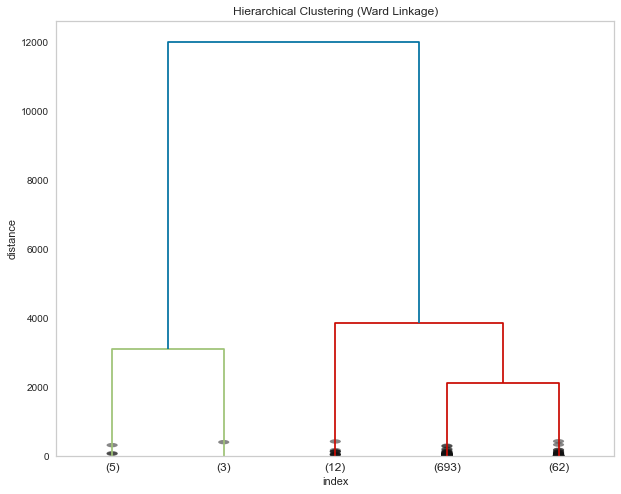

In [23]:
# Plot dendrogram
for i in [X_small, X_medium, X_big]:
        compl=linkage(i,"ward")
        plt.figure(figsize=(10,8))
        plt.grid(visible=None)
        plt.title("Hierarchical Clustering (Ward Linkage)")
        plt.xlabel("index")
        plt.ylabel("distance")
        dendrogram(compl, truncate_mode="lastp",p=5,show_contracted=True);
        plt.show()

2.2 Check Silhouette Score

In [24]:
for i in [X_small, X_medium, X_big]:
    for j in ['complete', 'average', 'ward']:
        hc =AgglomerativeClustering(n_clusters=5, linkage=j)
        clusters = hc.fit_predict(i)
        
        # Compute the silhouette score
        ss = silhouette_score(i, clusters)
        # chs = calinski_harabasz_score(X_small, clusters)
        print(str(j) + " linkage: ")
        print("Silhouette Score: ", ss)
        # print("Calinski-Harabasz Index: ", chs)
        print("-------------------------------------------")

complete linkage: 
Silhouette Score:  0.975811843765205
-------------------------------------------
average linkage: 
Silhouette Score:  0.9843588921063813
-------------------------------------------
ward linkage: 
Silhouette Score:  0.975811843765205
-------------------------------------------
complete linkage: 
Silhouette Score:  0.9779237721895041
-------------------------------------------
average linkage: 
Silhouette Score:  0.9732162005213982
-------------------------------------------
ward linkage: 
Silhouette Score:  0.9631418360021573
-------------------------------------------
complete linkage: 
Silhouette Score:  0.9200570407082908
-------------------------------------------
average linkage: 
Silhouette Score:  0.9487393212693367
-------------------------------------------
ward linkage: 
Silhouette Score:  0.8145057977698987
-------------------------------------------


2.3 Run Hierarchical Clustering for each size category

2.3.1 Small Cities

In [25]:
hc_small =AgglomerativeClustering(n_clusters=5, linkage='average')
clusters_small = hc_small.fit_predict(X_small)

X_small_hc = X_small.copy()
X_small_hc['clusters'] = clusters_small

In [26]:
# Check number of cities per cluster
np.bincount(clusters_small)

array([    2,     2, 11912,     1,     3])

In [27]:
# Check the average values of each cluster
# X_small_hc.groupby('clusters').mean()

In [28]:
#Check average values of each cluster using inverse transform
pd.DataFrame(scaler.inverse_transform(X_small_hc.groupby('clusters').mean() ), columns = list(X_small_hc.columns)[:-1])

,Median Household Income,Median Home Value,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Drove Alone to Work,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households Below the Poverty Leve,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,place,land_area,water_area,cases_per_100K,deaths_per_100K
0,62760.500000,247300.000000,20.893454,16.990083,11.758368,4.220316,34.586845,7.378653,1.519601,2.132281,76.037062,19.221063,2.101723e-01,0.210172,3.104550,1.544241,18.339970,0.973153,2.101723e-02,2.951511,0.289208,40930.000000,2.190750e+08,2.455619e+08,2286.285569,0.000000
1,56282.000000,191550.000000,54.001433,1.055901,11.545628,8.772097,27.171524,23.941710,5.011945,1.827520,27.854754,17.773531,9.866221e-01,4.359771,9.209269,6.333015,9.479216,4.278548,1.397516e+00,48.268036,2.262303,48717.000000,6.250601e+07,4.433198e+08,4349.306017,71.248272
2,53112.080843,135744.620131,85.398992,7.167189,8.749746,15.750495,22.649681,19.209212,6.563544,2.162226,43.778045,35.429607,9.172669e-01,1.058147,6.515308,3.959984,4.301781,6.076113,6.003902e-01,9.317527,0.800421,41364.156061,5.875278e+06,2.297061e+05,6894.137666,117.425264
3,58438.000000,221700.000000,65.179283,3.944223,8.605578,15.298805,21.952191,23.027888,5.537849,1.115538,40.278884,28.047809,1.673307e+00,1.792829,11.035857,4.302789,6.454183,1.952191,7.968127e-02,18.406375,0.199203,86380.000000,6.619997e+09,2.384375e+09,1161.971159,0.000000
4,45297.666667,55800.000000,18.198968,4.609929,4.282662,9.954324,34.267233,11.071567,1.609468,4.015133,41.458491,7.828445,-1.110223e-16,1.573386,3.481788,9.753552,8.685090,3.790946,-5.551115e-17,76.465824,4.432624,41731.666667,1.163073e+08,9.990814e+07,6397.610537,23.182499


2.3.2 Medium Cities

In [29]:
hc_medium =AgglomerativeClustering(n_clusters=5, linkage='complete')
clusters_medium = hc_medium.fit_predict(X_medium)

X_medium_hc = X_medium.copy()
X_medium_hc['clusters'] = clusters_medium

In [30]:
# Check number of cities per cluster
np.bincount(clusters_medium)

array([3965,    2,    1,    1,    1])

In [31]:
#Check average values of each cluster using inverse transform
pd.DataFrame(scaler.inverse_transform(X_medium_hc.groupby('clusters').mean() ), columns = list(X_medium_hc.columns)[:-1])

,Median Household Income,Median Home Value,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Drove Alone to Work,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households Below the Poverty Leve,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,place,land_area,water_area,cases_per_100K,deaths_per_100K
0,66451.165448,242136.977049,76.848087,14.288243,12.957327,14.112993,26.214117,16.739253,5.598336,2.164737,46.104809,36.043411,1.089683,1.322523,5.658785,3.348637,3.629773,5.119300,0.642140,4.888912,1.391297,42141.44338,2.903546e+07,1.392744e+06,6410.536249,106.417939
1,100521.500000,339250.000000,94.892125,4.096093,13.916099,20.711448,17.549324,14.873983,3.023437,3.514985,49.578497,42.440641,1.238705,1.429186,8.693034,0.524248,0.872100,1.690041,0.354756,0.763138,0.884754,50084.00000,5.372060e+07,1.618760e+08,5048.293414,28.498860
2,88077.000000,355100.000000,66.357207,6.925449,17.826101,14.034705,25.960310,13.632823,5.165270,2.386367,51.319356,34.116328,1.208760,2.327175,6.539145,2.663634,4.246238,2.629365,1.018723,2.847441,1.657373,36400.00000,7.003265e+09,1.426373e+09,1997.030120,4.673043
3,81708.000000,365800.000000,64.406582,6.908624,15.684444,14.984246,22.336329,16.197923,5.193138,1.400397,54.078656,34.823200,1.750496,2.100595,6.290116,1.937216,5.753297,2.369005,0.886918,7.667172,0.875248,70540.00000,7.433305e+09,5.037858e+09,2080.664335,7.888924
4,49229.000000,131400.000000,55.931107,30.078030,7.661519,15.513059,26.449422,14.997574,4.657556,2.156950,41.723943,34.707286,0.299183,1.265465,5.957387,1.776906,6.234333,5.587450,0.410366,4.827363,1.920433,72392.00000,1.665489e+08,3.140488e+08,6347.452607,64.277251


2.3.3 Big Cities

In [32]:
hc_big =AgglomerativeClustering(n_clusters=5, linkage='average')
clusters_big= hc_big.fit_predict(X_big)

X_big_hc = X_big.copy()
X_big_hc['clusters'] = clusters_big

In [33]:
# Check number of cities per cluster
np.bincount(clusters_big)

array([767,   2,   1,   4,   1])

In [34]:
#Check average values of each cluster using inverse transform
pd.DataFrame(scaler.inverse_transform(X_big_hc.groupby('clusters').mean() ), columns = list(X_big_hc.columns)[:-1])

,Median Household Income,Median Home Value,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Drove Alone to Work,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households Below the Poverty Leve,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,place,land_area,water_area,cases_per_100K,deaths_per_100K
0,69559.336375,327560.496741,64.276203,23.748271,14.499231,11.871940,29.948022,14.238244,4.483710,2.124151,48.064882,35.943834,1.096064,1.427482,4.815159,3.869456,4.000439,4.932767,0.566509,3.477932,1.550874,42229.594524,1.342172e+08,7.567079e+06,6199.897216,94.797993
1,81474.500000,303750.000000,63.127560,8.894426,15.541359,14.224595,25.867101,12.638501,3.686565,2.343990,52.566819,40.839784,1.230674,1.429198,11.064405,2.154758,3.402731,2.750772,0.781417,3.411274,0.963846,42500.000000,2.527210e+09,6.345795e+08,5001.999114,33.357652
2,57387.000000,150100.000000,81.693797,63.789944,9.231090,14.902615,27.661706,13.952355,3.890210,2.536680,45.814998,37.742238,0.787542,0.771300,7.045279,2.441992,7.943138,5.742924,0.504088,4.650479,2.212777,17000.000000,4.136301e+08,8.521655e+08,5220.019050,145.126654
3,70180.000000,558475.000000,48.137986,19.933558,18.076187,8.406722,37.930082,15.769776,5.837936,1.423922,48.852365,22.691678,1.209100,1.696929,3.802523,5.539653,4.574814,7.027882,0.373941,9.732944,1.004292,50267.000000,3.612034e+08,4.541751e+08,5405.981378,111.956031
4,55531.000000,187700.000000,56.283075,10.418864,13.475193,13.684614,28.865425,13.806389,4.463106,2.270944,48.683085,38.324609,1.246111,1.406556,8.808538,2.597597,5.601847,5.330597,0.683112,4.467760,1.973212,35000.000000,1.935930e+09,3.294578e+08,6198.579223,81.908988


For all three size categories, the size of the clusters are still very uneven.

# Model 3: DBSCAN

Find the optimal eps and min_samples based on Silhouette Score

3.1 Small Cities

In [35]:
# min_samples = range(15,31)
# eps = np.arange(0.01, 0.15, 0.001)
# res = []

# for i in min_samples:
#     for j in eps:
#         dbscan = DBSCAN(min_samples=i, eps=j)
#         clusters = dbscan.fit_predict(X_RS)
#         score = silhouette_score(X_RS, clusters)
#         res.append((i, j, score))
# Results: cannot find a good combination of parameters for DBSCAN because no clusters are found

dbscan = DBSCAN(min_samples=15, eps=0.01)
clusters_small = dbscan.fit_predict(X_small)

In [36]:
X_small_db = X_small.copy()
X_small_db['clusters'] = clusters_small

In [37]:
# Check the average values of each cluster
X_small_db.groupby('clusters').mean()

,Median Household Income,Median Home Value,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Drove Alone to Work,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households Below the Poverty Leve,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,place,land_area,water_area,cases_per_100K,deaths_per_100K
clusters,,,,,,,,,,,,,,,,,,,,,,,,,,
-1,0.071956,0.171201,-0.240336,0.356375,0.027534,0.11496,-0.022788,0.221714,0.232256,0.113265,-0.133068,-0.061366,0.224591,0.113968,0.214873,0.244685,0.280356,0.207444,0.332841,0.700061,0.380403,-0.008529,0.141194,3.187546,0.108017,0.192825


3.2 Medium Cities

In [38]:
dbscan = DBSCAN(min_samples=15, eps=0.01)
clusters_medium = dbscan.fit_predict(X_medium)

In [39]:
X_medium_db = X_medium.copy()
X_medium_db['clusters'] = clusters_medium

In [40]:
# Check the average values of each cluster
X_medium_db.groupby('clusters').mean()

,Median Household Income,Median Home Value,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Drove Alone to Work,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households Below the Poverty Leve,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,place,land_area,water_area,cases_per_100K,deaths_per_100K
clusters,,,,,,,,,,,,,,,,,,,,,,,,,,
-1,0.623613,1.221081,-0.683396,1.142069,0.590384,-0.129206,0.356987,-0.069962,-0.003091,0.114936,0.084846,0.001425,0.378833,0.334632,-0.03072,0.082354,0.104807,0.005592,0.384959,-0.03439,0.859277,0.010667,2.372769,18.1677,-0.06144,0.055898


3.3 Big Cities

In [41]:
dbscan = DBSCAN(min_samples=15, eps=0.01)
clusters_big = dbscan.fit_predict(X_big)

In [42]:
X_big_db = X_big.copy()
X_big_db['clusters'] = clusters_big

In [43]:
# Check the average values of each cluster
X_big_db.groupby('clusters').mean()

,Median Household Income,Median Home Value,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Drove Alone to Work,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households Below the Poverty Leve,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,place,land_area,water_area,cases_per_100K,deaths_per_100K
clusters,,,,,,,,,,,,,,,,,,,,,,,,,,
-1,0.751042,2.069836,-1.341058,2.18444,0.798185,-0.466521,0.75943,-0.364771,-0.27363,0.088383,0.26915,-0.013749,0.385114,0.422303,-0.268447,0.220595,0.203221,-0.031687,0.290397,-0.261004,0.986636,0.012396,11.873186,74.512454,-0.137022,-0.08716


DBSCAN may not be ideal for this dataset. It is not finding any clusters.

# Model 4: Gaussian Mixture Model (GMM)

Use Bayesian Information Criterion (BIC) to estimate the optimal number of clusters for GMM

4.1 Small Cities

In [44]:
# create GMM models with different number of components
n_components = np.arange(1, 11)
models = [GaussianMixture(n, covariance_type='full', random_state=0) for n in n_components]

# compute the BIC score for each model
bics = [model.fit(X_small).bic(X_small) for model in models]

# estimate the optimal number of clusters 
n_clusters = n_components[np.argmin(bics)]

In [45]:
# create a GMM with the optimal number of clusters
gmm = GaussianMixture(n_components=n_clusters)
gmm.fit(X_small)
clusters = gmm.predict(X_small)

In [46]:
# Check number of cities per cluster
np.bincount(clusters)

array([5204,    1,    1,    2,    4,    7, 5156,    1, 1544])

In [47]:
X_small_gmm = X_small.copy()
X_small_gmm['clusters'] = clusters

In [48]:
#Check average values of each cluster using inverse transform
pd.DataFrame(scaler.inverse_transform(X_small_gmm.groupby('clusters').mean()), columns=list(X_small_gmm.columns)[:-1])

,Median Household Income,Median Home Value,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Drove Alone to Work,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households Below the Poverty Leve,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,place,land_area,water_area,cases_per_100K,deaths_per_100K
0,50322.943697,102509.415257,86.574116,7.475234,7.798916,16.168119,22.427171,18.812888,6.446488,2.220743,44.519569,36.357067,0.827897,0.996147,6.487563,3.898358,4.362975,5.994656,0.512413,7.571442,0.362440,40855.145465,2.645983e+06,1.122233e+01,7378.163614,127.169808
1,58438.000000,221700.000000,65.179283,3.944223,8.605578,15.298805,21.952191,23.027888,5.537849,1.115538,40.278884,28.047809,1.673307,1.792829,11.035857,4.302789,6.454183,1.952191,0.079681,18.406375,0.199203,86380.000000,6.619997e+09,2.384375e+09,1161.971159,0.000000
2,65481.000000,309100.000000,97.453416,2.111801,21.552795,4.906832,20.496894,34.037267,9.254658,0.248447,36.149068,30.931677,1.863354,0.807453,15.341615,0.248447,7.639752,1.304348,2.795031,90.931677,3.975155,19744.000000,1.620418e+07,4.136052e+08,6246.240733,122.229013
3,62760.500000,247300.000000,20.893454,16.990083,11.758368,4.220316,34.586845,7.378653,1.519601,2.132281,76.037062,19.221063,0.210172,0.210172,3.104550,1.544241,18.339970,0.973153,0.021017,2.951511,0.289208,40930.000000,2.190750e+08,2.455619e+08,2286.285569,0.000000
4,47338.750000,120725.000000,37.522709,4.159353,7.059484,9.753438,29.374602,17.445789,5.158574,3.089339,41.475151,12.803743,0.519931,1.873281,5.748256,7.592461,7.623003,4.229691,0.000000,81.240183,3.948385,35426.750000,9.322657e+07,9.320327e+07,5969.401320,39.298142
5,62936.857143,288357.142857,34.445581,4.061009,7.629632,13.988317,34.793765,14.778923,2.748850,3.017022,41.208659,15.086201,0.898340,1.252911,4.321590,7.378702,10.838200,7.247195,0.265876,25.518915,0.663049,45192.142857,2.609309e+07,4.433511e+07,3685.960673,28.384697
6,50151.121800,120256.943367,84.923402,5.648411,8.111351,16.162621,22.967074,18.417839,6.415498,2.222090,43.128615,35.487405,0.725909,0.995879,6.346403,4.195875,4.185529,6.523205,0.538423,6.960157,0.833570,41655.384019,6.225948e+06,9.737738e+04,6632.427808,113.170002
7,47083.000000,74000.000000,10.549451,0.000000,1.538462,12.637363,33.846154,13.846154,0.769231,3.406593,19.560440,4.615385,0.109890,7.912088,3.076923,12.417582,11.318681,7.252747,0.000000,5.604396,0.549451,77690.000000,1.088078e+08,4.730344e+08,2452.371301,20.267531
8,72355.766839,298673.651554,83.250916,11.217616,14.087103,12.978931,22.289843,23.196550,7.463771,1.762414,43.460568,32.207844,1.856838,1.473062,7.178898,3.366311,4.454017,4.852690,1.105751,22.945491,2.165451,42105.979922,1.548510e+07,1.198632e+06,6152.668490,99.214502


4.2 Medium Cities

In [49]:
# create GMM models with different number of components
n_components = np.arange(1, 11)
models = [GaussianMixture(n, covariance_type='full', random_state=0) for n in n_components]

# compute the BIC score for each model
bics_medium = [model.fit(X_medium).bic(X_medium) for model in models]

# estimate the optimal number of clusters 
n_clusters_medium = n_components[np.argmin(bics_medium)]

In [50]:
# create a GMM with the optimal number of clusters
gmm = GaussianMixture(n_components=n_clusters_medium)
gmm.fit(X_medium)
clusters_medium = gmm.predict(X_medium)

In [51]:
# Check number of cities per cluster
np.bincount(clusters_medium)

array([1743,    1,    1,    2,    1,   27,  520,    2,    8, 1665])

In [52]:
X_medium_gmm = X_medium.copy()
X_medium_gmm['clusters'] = clusters_medium

In [53]:
#Check average values of each cluster using inverse transform
pd.DataFrame(scaler.inverse_transform(X_medium_gmm.groupby('clusters').mean()), columns=list(X_medium_gmm.columns)[:-1])

,Median Household Income,Median Home Value,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Drove Alone to Work,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households Below the Poverty Leve,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,place,land_area,water_area,cases_per_100K,deaths_per_100K
0,47677.372347,145221.686747,70.385786,19.268105,8.588277,13.517199,29.746595,15.833278,5.733582,2.245614,42.978677,33.723391,0.644221,1.188221,5.641464,4.447603,4.519296,7.056005,0.438934,5.076934,0.753266,41187.782559,2.207319e+07,2.404261e+05,6632.098087,115.856703
1,81708.000000,365800.000000,64.406582,6.908624,15.684444,14.984246,22.336329,16.197923,5.193138,1.400397,54.078656,34.823200,1.750496,2.100595,6.290116,1.937216,5.753297,2.369005,0.886918,7.667172,0.875248,70540.000000,7.433305e+09,5.037858e+09,2080.664335,7.888924
2,88077.000000,355100.000000,66.357207,6.925449,17.826101,14.034705,25.960310,13.632823,5.165270,2.386367,51.319356,34.116328,1.208760,2.327175,6.539145,2.663634,4.246238,2.629365,1.018723,2.847441,1.657373,36400.000000,7.003265e+09,1.426373e+09,1997.030120,4.673043
3,87129.500000,468250.000000,83.149377,21.678068,17.508896,19.623223,19.792222,22.343739,5.035208,1.540644,39.647771,24.986149,0.908401,1.956358,7.768206,2.350617,4.134220,5.267921,3.004425,8.382803,4.406016,3668.000000,5.203792e+07,1.001498e+08,3280.492221,71.640781
4,49229.000000,131400.000000,55.931107,30.078030,7.661519,15.513059,26.449422,14.997574,4.657556,2.156950,41.723943,34.707286,0.299183,1.265465,5.957387,1.776906,6.234333,5.587450,0.410366,4.827363,1.920433,72392.000000,1.665489e+08,3.140488e+08,6347.452607,64.277251
5,84405.074074,451388.888889,81.244787,7.733396,20.435929,10.870331,22.811566,25.291097,7.532201,1.495743,46.063934,33.868220,2.120440,1.389390,6.984062,2.740422,2.915939,4.391452,0.830946,14.211186,1.512325,37055.037037,4.319275e+07,3.506526e+07,5134.199862,102.270807
6,81372.563462,472664.257692,75.099223,16.954033,16.739991,11.657517,25.501675,20.223826,6.452946,1.829022,45.787824,33.154252,1.767859,1.331641,6.215005,2.972957,3.786554,4.499593,0.769472,11.129873,2.182326,42202.584615,5.214393e+07,4.052596e+06,5802.993713,89.448564
7,100521.500000,339250.000000,94.892125,4.096093,13.916099,20.711448,17.549324,14.873983,3.023437,3.514985,49.578497,42.440641,1.238705,1.429186,8.693034,0.524248,0.872100,1.690041,0.354756,0.763138,0.884754,50084.000000,5.372060e+07,1.618760e+08,5048.293414,28.498860
8,78364.875000,505112.500000,80.963290,19.963291,15.104030,12.357395,25.688964,18.154913,4.903443,2.027291,49.250640,37.451406,1.810822,1.286556,6.638013,1.730007,3.978409,3.551476,0.762961,9.828562,1.588097,29404.750000,8.007651e+07,6.723013e+07,6667.531822,70.425149
9,81071.088889,266667.507508,84.060678,8.312680,16.212623,15.557974,22.804073,16.447183,5.162505,2.197178,49.469693,39.416227,1.324249,1.458597,5.474474,2.334356,2.658908,3.304565,0.808619,2.563851,1.805639,43310.578979,2.860439e+07,7.873364e+05,6391.560297,102.118706


4.3 Big Cities

In [54]:
# create GMM models with different number of components
n_components = np.arange(1, 11)
models = [GaussianMixture(n, covariance_type='full', random_state=0) for n in n_components]

# compute the BIC score for each model
bics_big = [model.fit(X_medium).bic(X_big) for model in models]

# estimate the optimal number of clusters 
n_clusters_big = n_components[np.argmin(bics_big)]

In [55]:
# create a GMM with the optimal number of clusters
gmm = GaussianMixture(n_components=n_clusters_big)
gmm.fit(X_big)
clusters_big = gmm.predict(X_big)

In [56]:
# Check number of cities per cluster
np.bincount(clusters_big)

array([775])

In [57]:
X_big_gmm = X_big.copy()
X_big_gmm['clusters'] = clusters_big

In [58]:
#Check average values of each cluster using inverse transform
pd.DataFrame(scaler.inverse_transform(X_big_gmm.groupby('clusters').mean()), columns=list(X_big_gmm.columns)[:-1])

,Median Household Income,Median Home Value,Race: White Alone,Hispanic or Latino,Population Age 25 or Older: Bachelor`s Degree,Pop 5-17 Speak only English at Home,Population Age 15 or Older Never Married,Population Age 65 or more,Pop 65 or more Living in Nonfamily Households,Females 20-64 w Own Children 0-17,Workers Age 16 or more,Workers 16 or more who Drove Alone to Work,Male 16+: Private For-Profit Self-Emp Inc Bus,Male 16+: Private Not-For-Profit Worker,Civilian Population 18+: Veteran,Population 35-64: Medicaid Coverage Only,Population 35-64: No Health Insurance Coverage,Households Below the Poverty Leve,Owner Households by Year Moved In: 2017 or Later,Total Vacant Housing Units,Housing Units Built in 2014 or Later,place,land_area,water_area,cases_per_100K,deaths_per_100K
0,69559.48129,328281.420645,64.202106,23.724717,14.512263,11.866376,29.974342,14.241095,4.48785,2.121826,48.078459,35.893463,1.096791,1.428003,4.83409,3.870168,4.009015,4.939508,0.56614,3.512834,1.547937,42229.892903,1.442495e+08,1.299540e+07,6191.442177,94.776304


# References
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html 
- In class exercises week 12, 13, 14
- https://stackoverflow.com/questions/53310228/how-can-i-make-seaborn-distribution-subplots-in-a-loop
- https://stackabuse.com/bytes/agglomerative-hierarchical-clustering-with-scikit-learn/
- https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/
- https://medium.com/@haataa/how-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c